In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

gdf = pd.read_pickle('/srv/scratch/z5297792/FishSOOP/gdf_fishsoo_seaus.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))


In [3]:
gdf

TEMPERATURE  PRES  TEMPERATURE_quality_control  \
TRAJECTORY DEPTH                                                      
0          0.993262    20.378000   1.0                            3   
           1.986520    19.990999   2.0                            1   
           2.979773    19.945999   3.0                            1   
           1.887194    19.973000   1.9                            3   
1          1.092593    24.181000   1.1                            3   
...                          ...   ...                          ...   
5650       6.850858    22.790001   6.9                            1   
           4.865126    22.798000   4.9                            1   
           3.475101    22.799000   3.5                            1   
           1.489336    22.799999   1.5                            1   
           0.000000    22.698999   0.0                            3   

                     DEPTH_quality_control  LATITUDE_quality_control  \
TRAJECTORY DEPTH                                                       
0          0.993262                      1                         1   
           1.986520                      1                         1   
           2.979773                      1                         1   
           1.887194                      1                         1   
1          1.092593                      1                         1   
...                                    ...                       ...   
5650       6.850858                      1                         2   
           4.865126                      1                         2   
           3.475101                      1                         2   
           1.489336                      1                         2   
           0.000000                      1                         2   

                     LONGITUDE_quality_control  PRES_quality_control  \
TRAJECTORY DEPTH                                                       
0          0.993262                          1                     1   
           1.986520                          1                     1   
           2.979773                          1                     1   
           1.887194                          1                     1   
1          1.092593                          1                     1   
...                                        ...                   ...   
5650       6.850858                          2                     1   
           4.865126                          2                     1   
           3.475101                          2                     1   
           1.489336                          2                     1   
           0.000000                          2                     1   

                                             TIME                     geometry  
TRAJECTORY DEPTH                                                                
0          0.993262 2021-11-20 22:24:37.999999744   POINT (153.4339 -29.12272)  
           1.986520 2021-11-20 22:24:41.999999744   POINT (153.4339 -29.12272)  
           2.979773 2021-11-20 22:24:48.000000000   POINT (153.4339 -29.12272)  
           1.887194 2021-11-20 22:25:16.999999744  POINT (153.43385 -29.12276)  
1          1.092593 2021-11-29 08:17:27.000000000   POINT (153.67332 -29.0671)  
...                                           ...                          ...  
5650       6.850858 2025-06-30 13:59:59.000000000   POINT (152.5166 -33.67196)  
           4.865126 2025-06-30 14:00:01.000000000   POINT (152.5166 -33.67196)  
           3.475101 2025-06-30 14:00:02.000000000   POINT (152.5166 -33.67196)  
           1.489336 2025-06-30 14:00:03.000000000   POINT (152.5166 -33.67196)  
           0.000000 2025-06-30 14:00:04.000000000   POINT (152.5166 -33.67196)  

[2889960 rows x 9 columns]

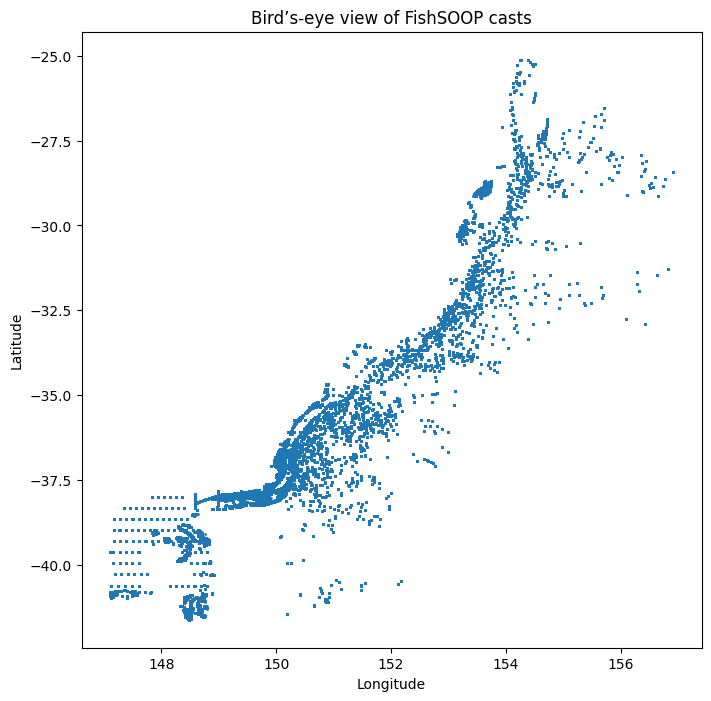

In [17]:
# Cruise times
t0, t1 = pd.Timestamp('2023-10-09 11:56:08.499988'), pd.Timestamp('2023-11-01 04:37:58.500000')

df_data = pd.DataFrame({'Lon': gdf.geometry.x, 'Lat': gdf.geometry.y, 'Time': gdf.TIME})
df_data = df_data[((df_data.Time < t0)|(df_data.Time > t1)) & ((df_data.Lon < 155)|(df_data.Lat > -35)) & (df_data.Lon < 158)]


plt.figure(figsize=(8, 8))
plt.scatter(df_data.Lon, df_data.Lat, s=1, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bird’s-eye view of FishSOOP casts")
plt.show()


In [22]:
x0, x1 = (np.float64(146.61067123413085), np.float64(157.40759353637696))
y0, y1 = (np.float64(-42.43737716674805), np.float64(-24.292496490478516))
z0, z1 = (np.float64(1.3167407676111906), np.float64(-0.07310091010294854))
z0, z1 = 0, 1000

### POLISHED

In [10]:
df_cast[(df_cast.Lon >=154)&(df_cast.Lon <=154.5)&(df_cast.Lat <=-37.5)&(df_cast.Lon >=-37.75)]

,Lon,Lat,Depth,Cast
2255904,154.179504,-37.500286,0.161824,916
2255905,154.179504,-37.500286,0.160238,916
2255906,154.179504,-37.500286,0.158849,917
2255907,154.179504,-37.500286,0.158353,916
2255908,154.179504,-37.500286,0.155973,916
...,...,...,...,...
2670168,154.267715,-38.822392,0.003970,900
2670169,154.267715,-38.822392,0.003573,901
2670170,154.267715,-38.822392,0.002283,901
2670171,154.267715,-38.822392,0.004962,901


(np.float64(146.3440976390258), np.float64(162.97394958045817)) (np.float64(-42.43737716674805), np.float64(-24.292496490478516)) (np.float64(-0.07310091010294854), np.float64(1.3167407676111906))


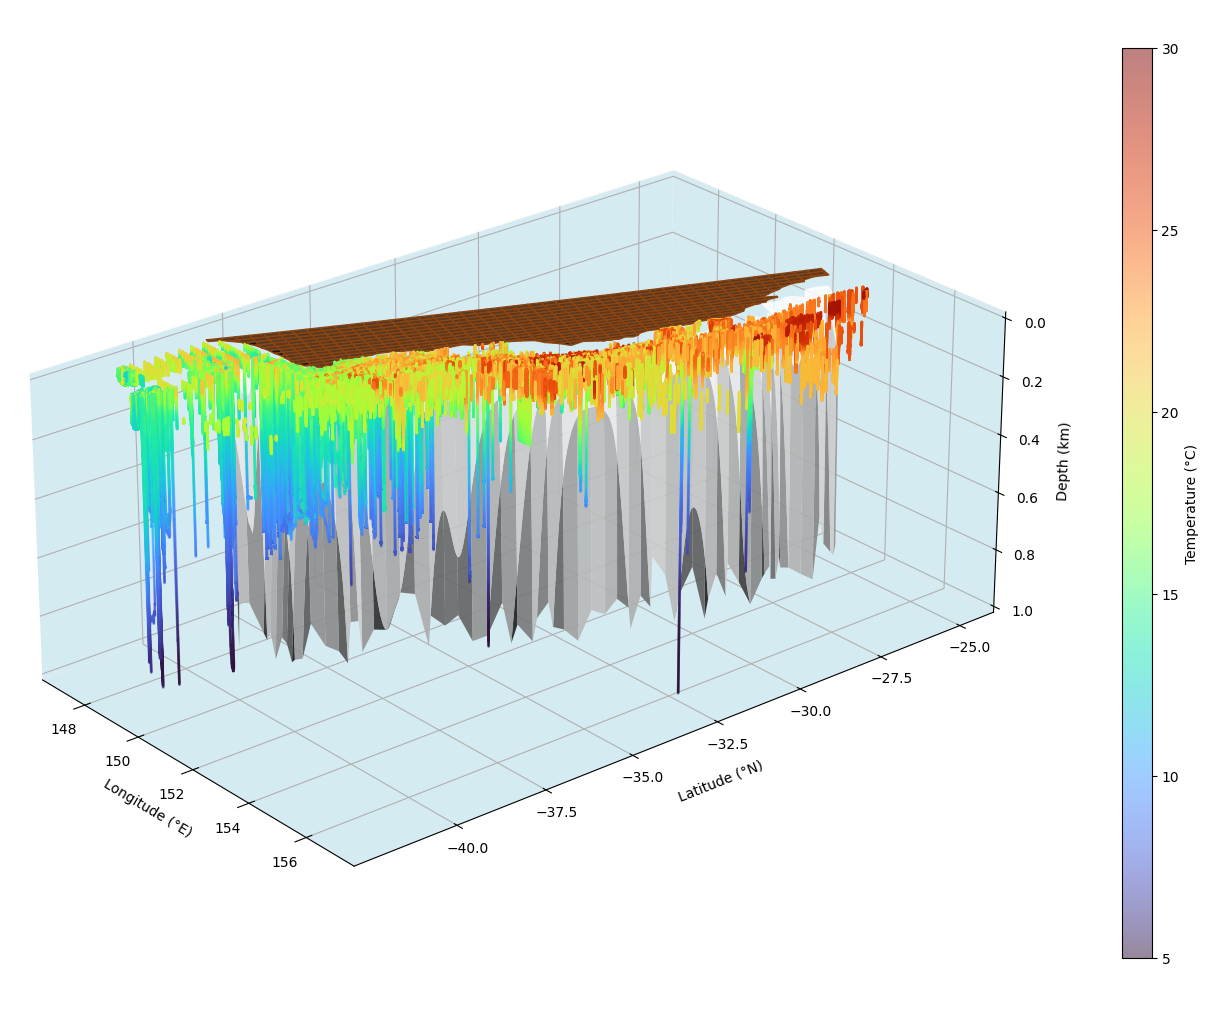

In [38]:
max_len = len(gdf.geometry.x)
# max_len = round(len(gdf.geometry.x)/10)
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
df_temp = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Temp': gdf['TEMPERATURE'][:max_len],
    'Time': gdf.TIME[:max_len]
})
df_temp = df_temp.sort_values("Lat", ascending=False).reset_index(drop=True)
df_temp = df_temp[((df_temp.Time < t0)|(df_temp.Time > t1)) & ((df_temp.Lon < 155)|(df_temp.Lat > -35)) & (df_temp.Lon < 158)]
m = np.isfinite(df_temp.Lon) & np.isfinite(df_temp.Lat) & np.isfinite(df_temp.Depth) & np.isfinite(df_temp.Temp)

fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.pane.set_facecolor("lightblue")
ax.yaxis.pane.set_facecolor("lightblue")
ax.zaxis.pane.set_facecolor("lightblue")

# --- land surface
surf_land = ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=0
)
surf_land.set_sort_zpos(-1e9)

# --- bathy surface (windowed)
h_mask = np.where(mask_rho, h, np.nan)/1000
h_mask = np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1)&(h_mask<=1), h_mask, np.nan)
surf_bathy = ax.plot_surface(
    lon_rho, lat_rho, h_mask,
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)
surf_bathy.set_sort_zpos(-1e9)

# --- scatter on top
sc = ax.scatter(
    df_temp.Lon[m], df_temp.Lat[m], df_temp.Depth[m],
    c=df_temp.Temp[m], cmap="turbo", s=1, alpha=0.5, vmin=5, vmax=30,
    depthshade=False, zorder=10
)
sc.set_sort_zpos(1e9)

print(ax.get_xlim(), ax.get_ylim(), ax.get_zlim())

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Depth (km)', labelpad=5)
ax.invert_zaxis()

# dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([15, 25, 10])

# ax.view_init(elev=35, azim=-60)
ax.view_init(elev=25, azim=-40)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); 
ax.set_zlim(1, 0)

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label="Temperature (°C)")
plt.show()


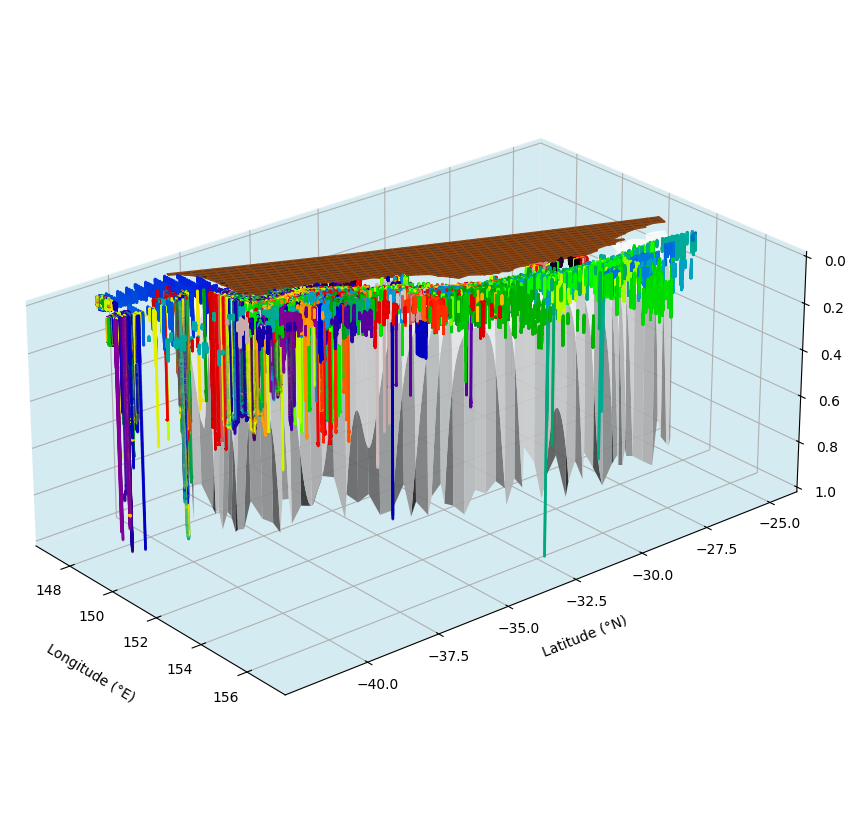

In [43]:
max_len = len(gdf.geometry.x)
# max_len = round(len(gdf.geometry.x)/10)
depth = gdf['DEPTH'] if 'DEPTH' in gdf.columns else gdf.index.get_level_values('DEPTH')
casts = gdf['TRAJECTORY'] if 'TRAJECTORY' in gdf.columns else gdf.index.get_level_values('TRAJECTORY')
df_cast = pd.DataFrame({
    'Lon': gdf.geometry.x[:max_len],
    'Lat': gdf.geometry.y[:max_len],
    'Depth': depth[:max_len] / 1000,
    'Cast': casts[:max_len],
    'Time': gdf.TIME[:max_len]
})
df_cast = df_cast.sort_values("Lat", ascending=False).reset_index(drop=True)
df_cast = df_cast[((df_cast.Time < t0)|(df_cast.Time > t1)) & ((df_cast.Lon < 155)|(df_cast.Lat > -35)) & (df_cast.Lon < 158)]

codes, uniques = pd.factorize(df_cast.Cast)   # integer 0..K-1 per cast

m = np.isfinite(df_cast.Lon) & np.isfinite(df_cast.Lat) & np.isfinite(df_cast.Depth) & np.isfinite(df_cast.Cast)

fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.pane.set_facecolor("lightblue")
ax.yaxis.pane.set_facecolor("lightblue")
ax.zaxis.pane.set_facecolor("lightblue")

ax.plot_surface(
    lon_rho, lat_rho, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown", alpha=0.9, zorder=1
)

h_mask = np.where(mask_rho, h, np.nan)/1000
h_mask = np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1)&(h_mask<=1), h_mask, np.nan)
ax.plot_surface(
    lon_rho, lat_rho, np.where((lon_rho>=x0)&(lon_rho<=x1)&(lat_rho>=y0)&(lat_rho<=y1), h_mask, np.nan),
    cmap="Greys", edgecolor="none", alpha=0.9, zorder=0
)

sc = ax.scatter(
    df_cast.Lon[m], df_cast.Lat[m], df_cast.Depth[m],
    c=df_cast.Cast[m], cmap="nipy_spectral", s=1, alpha=0.6, zorder=2
)

# ax = fig.add_axes([0.05, 0.1, 0.7, 0.8], projection='3d')
ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Depth (km)', labelpad=5)
ax.invert_zaxis()
# dx, dy, dz = np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())
ax.set_box_aspect([15, 25, 10])

ax.view_init(elev=25, azim=-40)
ax.set_xlim(x0, x1); ax.set_ylim(y0, y1); 
ax.set_zlim(1, 0)

pos = ax.get_position()         # [left, bottom, width, height]
ax.set_position([pos.x0, pos.y0, pos.width*0.8, pos.height])

plt.show()
